In [1]:
%load_ext autotime

time: 1.44 ms


In [2]:
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pylab as plt
from collections import Counter
from sklearn.manifold import TSNE

time: 5.95 s


In [3]:
age_seq = pickle.load(open("../../DATA/age_seq","rb"))
sex_seq = pickle.load(open("../../DATA/sex_seq","rb"))

time: 41.1 ms


In [4]:
code_seq_2013 = pickle.load(open("../../DATA/code_seq_2013","rb"))
cost_seq_2013 = pickle.load(open("../../DATA/cost_seq_2013","rb"))
date_seq_2013 = pickle.load(open("../../DATA/date_seq_2013","rb"))
util_seq_2013 = pickle.load(open("../../DATA/util_seq_2013","rb"))

time: 13.7 s


In [5]:
code_seq_2014 = pickle.load(open("../../DATA/code_seq_2014","rb"))
cost_seq_2014 = pickle.load(open("../../DATA/cost_seq_2014","rb"))
date_seq_2014 = pickle.load(open("../../DATA/date_seq_2014","rb"))
util_seq_2014 = pickle.load(open("../../DATA/util_seq_2014","rb"))

time: 19.2 s


In [6]:
TMAE_Embedding = pickle.load(open("../../MODELS/TMAE/Embeddings/TMAE_Embedding_100","rb"))

time: 139 ms


In [7]:
from sklearn.metrics import silhouette_score

def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
        sse.append(curr_sse)
    return sse

def calculate_SIL(x, kmax = 10):
    sil = []
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    return sil

time: 2.49 ms


In [8]:
from sklearn.cluster import KMeans
from collections import Counter

time: 106 ms


In [9]:
icd3_seq = []

for p in code_seq_2013:
    p_codes = []
    for v in p:
        new_v = []
        for c in v:
            c = c[:5]
            new_v.append(c)
        p_codes.extend(list(set(new_v)))
    icd3_seq.append(p_codes)

time: 2.95 s


In [10]:
def select_diag(icd3_code, freq=1):
    idx_seq = []
    for i, p_code in enumerate(icd3_seq):
        if icd3_code in p_code and Counter(p_code)[icd3_code]>=freq:
            idx_seq.append(i)
    return idx_seq

time: 813 µs


In [11]:
idx = select_diag("D_250", freq=1)
len(idx)

337

time: 189 ms


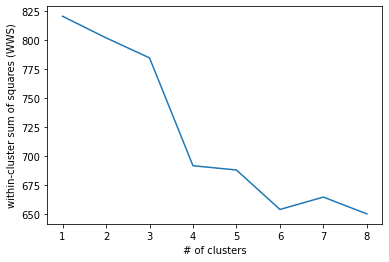

time: 1.08 s


In [42]:
kmax = 8
points = TMAE_Embedding[idx]
sse = calculate_WSS(points, kmax=kmax)
plt.plot(range(1, kmax+1), sse)
plt.xlabel("# of clusters")
plt.ylabel("within-cluster sum of squares (WWS)")
plt.savefig("diabetes", dpi=300)

In [26]:
from sklearn.cluster import KMeans

n=4
kmeans = KMeans(n_clusters=n, random_state=0).fit(TMAE_Embedding[idx])
group_id = {i: np.where(kmeans.labels_ == i)[0] for i in range(n)}

time: 96.4 ms


In [27]:
Counter(kmeans.labels_)

Counter({2: 38, 0: 94, 3: 99, 1: 106})

time: 18.3 ms


In [28]:
def cluster_output(seq_2013, seq_2014, k=2, mean_flag=False):
    for i in range(k):
        print("CLUSTERS:",i)
        cluster_idx = np.where(kmeans.labels_ == i)[0]
        if mean_flag: 
            print("2013:", np.mean(seq_2013[cluster_idx]))
            print("2014:", np.mean(seq_2014[cluster_idx]))
        else:
            print("2013:", np.median(seq_2013[cluster_idx]))
            print("2014:", np.median(seq_2014[cluster_idx]))
        print()

time: 1.5 ms


In [29]:
def generate_cost_seqs(cost_seq, util_seq):
    RX_cost, IP_cost, OP_cost = [],[],[]
    for p_cost, p_util in zip(cost_seq, util_seq):
        RX_, IP_, OP_ = 0, 0, 0
        for cost, util in zip(p_cost, p_util):
            if "RX" in util:
                RX_ += cost
            elif "IP" in util:
                IP_ += cost
            else:
                OP_ += cost
        RX_cost.append(RX_)
        IP_cost.append(IP_)
        OP_cost.append(OP_)
    return np.array(RX_cost), np.array(IP_cost), np.array(OP_cost), np.array([sum(k) for k in cost_seq])

def generate_util_seqs(util_seq):
    RX_visit, IP_visit, OP_visit = [],[],[]
    for p_util in util_seq:
        RX_, IP_, OP_ = 0, 0, 0
        for util in p_util:
            if "RX" in util:
                RX_ += 1
            elif "IP" in util:
                IP_ += 1
            else:
                OP_ += 1
        RX_visit.append(RX_)
        IP_visit.append(IP_)
        OP_visit.append(OP_)
    return np.array(RX_visit), np.array(IP_visit), np.array(OP_visit)



time: 2.82 ms


In [30]:
RX_2013, IP_2013, OP_2013, total_2013 = generate_cost_seqs(cost_seq_2013, util_seq_2013)
RX_2014, IP_2014, OP_2014, total_2014 = generate_cost_seqs(cost_seq_2014, util_seq_2014)

time: 7.76 s


In [24]:
cluster_output(RX_2013[idx], RX_2014[idx], k=n)

CLUSTERS: 0
2013: 5512.574999999999
2014: 6912.325

CLUSTERS: 1
2013: 104.32
2014: 143.47

CLUSTERS: 2
2013: 242.49
2014: 175.72

CLUSTERS: 3
2013: 3131.9799999999996
2014: 5516.780000000001

time: 1.86 ms


In [25]:
cluster_output(IP_2013[idx], IP_2014[idx], k=n)

CLUSTERS: 0
2013: 0.0
2014: 0.0

CLUSTERS: 1
2013: 0.0
2014: 0.0

CLUSTERS: 2
2013: 0.0
2014: 0.0

CLUSTERS: 3
2013: 0.0
2014: 0.0

time: 2.2 ms


In [26]:
cluster_output(OP_2013[idx], OP_2014[idx], k=n)

CLUSTERS: 0
2013: 873.255
2014: 881.825

CLUSTERS: 1
2013: 883.9449999999999
2014: 576.0799999999999

CLUSTERS: 2
2013: 937.145
2014: 548.875

CLUSTERS: 3
2013: 674.37
2014: 705.97

time: 2.46 ms


In [27]:
cluster_output(total_2013[idx], total_2014[idx], k=n)

CLUSTERS: 0
2013: 8150.07
2014: 9328.599999999999

CLUSTERS: 1
2013: 1179.2399999999998
2014: 913.3950000000002

CLUSTERS: 2
2013: 1653.835
2014: 1001.0250000000001

CLUSTERS: 3
2013: 6006.07
2014: 6676.349999999999

time: 3.38 ms


In [28]:
RX_2013, IP_2013, OP_2013 = generate_util_seqs(util_seq_2013)
RX_2014, IP_2014, OP_2014 = generate_util_seqs(util_seq_2014)

time: 1.99 s


In [29]:
cluster_output(RX_2013[idx], RX_2014[idx], k=n, mean_flag=True)

CLUSTERS: 0
2013: 13.96808510638298
2014: 18.30851063829787

CLUSTERS: 1
2013: 5.1415094339622645
2014: 6.5

CLUSTERS: 2
2013: 8.736842105263158
2014: 8.736842105263158

CLUSTERS: 3
2013: 14.535353535353535
2014: 20.2020202020202

time: 2.17 ms


In [30]:
cluster_output(IP_2013[idx], IP_2014[idx], k=n, mean_flag=True)

CLUSTERS: 0
2013: 0.2978723404255319
2014: 0.2553191489361702

CLUSTERS: 1
2013: 0.05660377358490566
2014: 0.04716981132075472

CLUSTERS: 2
2013: 0.10526315789473684
2014: 0.23684210526315788

CLUSTERS: 3
2013: 0.36363636363636365
2014: 0.08080808080808081

time: 7.59 ms


In [32]:
cluster_output(OP_2013[idx], OP_2014[idx], k=n, mean_flag=True)

CLUSTERS: 0
2013: 7.9361702127659575
2014: 9.127659574468085

CLUSTERS: 1
2013: 9.462264150943396
2014: 7.839622641509434

CLUSTERS: 2
2013: 7.552631578947368
2014: 8.394736842105264

CLUSTERS: 3
2013: 7.616161616161616
2014: 9.191919191919192

time: 3.88 ms


In [56]:
for i in range(n):
    print("CLUSTERS:",i)
    cluster_idx = np.where(kmeans.labels_ == i)[0]
    print("age", np.mean(np.array(age_seq)[idx][cluster_idx]))
    
    print(Counter(np.array(sex_seq)[idx][cluster_idx]))
    print([i/len(cluster_idx) for i in Counter(np.array(sex_seq)[idx][cluster_idx]).values()])
    print()




CLUSTERS: 0
age 11.797872340425531
Counter({'M': 50, 'F': 44})
[0.5319148936170213, 0.46808510638297873]

CLUSTERS: 1
age 11.726415094339623
Counter({'F': 63, 'M': 43})
[0.4056603773584906, 0.5943396226415094]

CLUSTERS: 2
age 14.368421052631579
Counter({'F': 21, 'M': 17})
[0.4473684210526316, 0.5526315789473685]

CLUSTERS: 3
age 11.252525252525253
Counter({'M': 52, 'F': 47})
[0.5252525252525253, 0.47474747474747475]

time: 153 ms


In [58]:
pcode_seq = []

for p in code_seq_2013:
    pcode = []
    for v in p:
        for c in v:
            pcode.append(c)
    pcode_seq.append(pcode)
    
pcode_seq = [pcode_seq[i] for i in idx]
len(pcode_seq)

337

time: 1.2 s


In [72]:
count_list = []
for i in range(n):
    print("CLUSTERS:",i)
    cluster_idx = np.where(kmeans.labels_ == i)[0]
    pcode_seq_cluster = [pcode_seq[i] for i in cluster_idx]
    codes = [c for p in pcode_seq_cluster for c in p]
    count_list.append(Counter(codes).most_common(10))

CLUSTERS: 0
CLUSTERS: 1
CLUSTERS: 2
CLUSTERS: 3
time: 13.5 ms


In [78]:
count_list[0]

[('M_FREESTYLE LITE STRIPS', 415),
 ('M_LANTUS SOLOSTAR', 397),
 ('M_HUMALOG', 341),
 ('D_250.01', 247),
 ('M_LANTUS', 246),
 ('M_BD ULTRA-FINE PEN NEEDLE', 237),
 ('M_KETOSTIX REAGENT', 218),
 ('M_GLUCAGON EMERGENCY KIT', 202),
 ('M_NOVOLOG FLEXPEN', 199),
 ('M_INSULIN SYRINGE', 191)]

time: 4.13 ms


In [74]:
count_list[1]

[('P_99213', 223),
 ('P_99214', 133),
 ('P_450', 105),
 ('D_250.00', 90),
 ('P_300', 85),
 ('P_510', 65),
 ('D_V20.2', 61),
 ('P_D1208', 58),
 ('P_99283', 51),
 ('P_D0120', 50)]

time: 5.84 ms


In [75]:
count_list[2]

[('M_METFORMIN HCL', 113),
 ('D_250.00', 93),
 ('P_510', 85),
 ('P_301', 58),
 ('P_942', 47),
 ('P_99214', 47),
 ('M_LISINOPRIL', 44),
 ('P_99213', 44),
 ('D_278.00', 40),
 ('P_300', 40)]

time: 3.67 ms


In [76]:
count_list[3]

[('D_250.01', 272),
 ('M_NOVOLOG', 251),
 ('D_250.03', 219),
 ('M_BD ULTRA-FINE PEN NEEDLE', 202),
 ('M_HUMALOG', 176),
 ('M_LANTUS SOLOSTAR', 161),
 ('M_TRUETEST TEST STRIPS', 146),
 ('P_99214', 136),
 ('M_GLUCAGON EMERGENCY KIT', 132),
 ('M_NOVOLOG FLEXPEN', 116)]

time: 3.37 ms


In [33]:
def generate_plot(Embedding, labels, color_dic, legend, title):
    tsne_model = TSNE(n_components=2, init='pca', random_state=23)
    new_values = tsne_model.fit_transform(Embedding)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color = color_dic[labels[i]], alpha=0.4)
    for i in range(len(color_dic)):
        plt.scatter(0,0, color=color_dic[i], label=legend[i], alpha=0.4)
    plt.legend()
    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(title)
    plt.show()

time: 2.27 ms


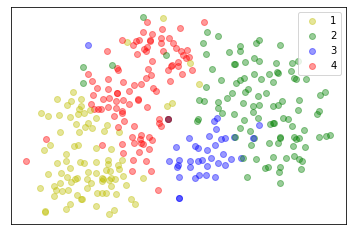

time: 9.7 s


In [43]:
# color_dic = {0:"y", 1:"g", 2:"b", 3:"r",4:"black"}
# legend = ["1", "2", "3", "4","5"]

color_dic = {0:"y", 1:"g", 2:"b", 3:"r"}
legend = ["1", "2", "3", "4"]

generate_plot(TMAE_Embedding[idx], kmeans.labels_, color_dic, legend, title="Diabetes_clusters")

In [ ]:
# diag2cat = pickle.load(open("../DATA/CCS/diag2cat","rb"))

# ccs_seq_2013 = []
# for p in code_seq_2013:
#     p_ccs = []
#     for v in p:
#         v_ccs = []
#         for c in v:
#             if c in diag2cat:
#                 new_c = diag2cat[c]
#                 v_ccs.append(new_c)
#         p_ccs.extend(list(set(v_ccs)))
#     ccs_seq_2013.append(p_ccs)
    
# def select_diag(code, code_seq, freq=1):
#     idx_seq = []
#     for i, p_code in enumerate(code_seq):
#         if code in p_code and Counter(p_code)[code]>=freq:
#             idx_seq.append(i)
#     return idx_seq

# idx = select_diag("49", ccs_seq_2013, freq=1)
# len(idx)

# d1_idx = select_diag("128", ccs_seq_2013, freq=3)[:1000]
# len(d1_idx)